# 表面蛋白捕获的单细胞 RNA 测序

一些实验流程涉及细胞表面蛋白的寡核苷酸标记抗体捕获，以同时得到 RNA 和表面蛋白的双模态数据，
在目前的技术下，这将得到一个附加的，一般不超过 500 中表面蛋白谱，表面蛋白的信号和 RNA 测序的
信号需要不同的标准化流程，因为数据的分布情况不尽相同

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import exprmat as em

# set working directory
em.setwd('/home/data/yangz/shared/tutorial/single-cell-rna')

In [3]:
ver = em.version()

[i] exprmat 0.1.48 / exprmat-db 0.1.48
[i] os: posix (linux)  platform version: 5.15.0-139-generic
[i] loaded configuration from /home/data/yangz/.exprmatrc
[i] current working directory: /home/data/yangz/shared/tutorial/single-cell-rna
[i] current database directory: /home/data/yangz/bioinfo/packages/database (0.1.48)
[i] resident memory: 811.50 MiB
[i] virtual memory: 5.78 GiB


下面的数据给出了一个 112 标的 CITE-seq 数据集，它取样于小鼠骨髓细胞，并为富集特定细胞群进行了
Lin- Sca-1+ cKit+ （LSK，富集造血干细胞）、IL7Ra+（富集淋巴系细胞）、和 cKit+（富集髓系细胞）
的分选，这里，我们为其创建元数据表

In [4]:
meta = em.metadata(
    # two samples from a murine tumor infiltrating cd8+ t cell dataset.
    locations    = [
        'src/bm-112-plex/hsc-mpp.h5',
        'src/bm-112-plex/il7ra-pos.h5',
        'src/bm-112-plex/kit-pos-1.h5',
        'src/bm-112-plex/kit-pos-2.h5',
        'src/bm-112-plex/kit-pos-3.h5'
    ],
    modality     = ['cite'] * 5,
    default_taxa = ['mmu'] * 5,
    batches      = ['b-1', 'b-2', 'b-3', 'b-4', 'b-5'],
    names        = ['hsc-mpp', 'il7ra', 'kit-1', 'kit-2', 'kit-3'],
    groups       = ['hsc', 'il7ra', 'kit', 'kit', 'kit']
)

可以看到，10X 的标准 H5 格式中同时包含了 RNA 和表面蛋白数据，我们将模态名设置为 `cite`

In [5]:
meta.dataframe

,location,sample,batch,group,modality,taxa
0,src/bm-112-plex/hsc-mpp.h5,hsc-mpp,b-1,hsc,cite,mmu
1,src/bm-112-plex/il7ra-pos.h5,il7ra,b-2,il7ra,cite,mmu
2,src/bm-112-plex/kit-pos-1.h5,kit-1,b-3,kit,cite,mmu
3,src/bm-112-plex/kit-pos-2.h5,kit-2,b-4,kit,cite,mmu
4,src/bm-112-plex/kit-pos-3.h5,kit-3,b-5,kit,cite,mmu


In [6]:
expm = em.experiment(meta, dump = 'cite')

[i] reading sample hsc-mpp [cite] ...
[i] 369 genes (out of 28692) not in the reference gene list.
[i] total 28323 genes mapped. 28260 unique genes.
[i] reading sample il7ra [cite] ...
[i] 369 genes (out of 28692) not in the reference gene list.
[i] total 28323 genes mapped. 28260 unique genes.
[i] reading sample kit-1 [cite] ...
[i] 369 genes (out of 28692) not in the reference gene list.
[i] total 28323 genes mapped. 28260 unique genes.
[i] reading sample kit-2 [cite] ...
[i] 369 genes (out of 28692) not in the reference gene list.
[i] total 28323 genes mapped. 28260 unique genes.
[i] reading sample kit-3 [cite] ...
[i] 369 genes (out of 28692) not in the reference gene list.
[i] total 28323 genes mapped. 28260 unique genes.


可以发现，程序自行将原始的 H5 格式文件的 RNA 模态和表面蛋白模态分割开来，因为它们需要不同的处理流程

In [7]:
print(expm)

[!] dataset not integrated.
[*] composed of samples:
  hsc-mpp   cite  mmu    batch b-1     of size 9868 × 112
  il7ra     cite  mmu    batch b-2     of size 11277 × 112
  kit-1     cite  mmu    batch b-3     of size 13837 × 112
  kit-2     cite  mmu    batch b-4     of size 11035 × 112
  kit-3     cite  mmu    batch b-5     of size 11568 × 112
  hsc-mpp   rna   mmu    batch b-1     of size 9868 × 28260
  il7ra     rna   mmu    batch b-2     of size 11277 × 28260
  kit-1     rna   mmu    batch b-3     of size 13837 × 28260
  kit-2     rna   mmu    batch b-4     of size 11035 × 28260
  kit-3     rna   mmu    batch b-5     of size 11568 × 28260



### RNA 模态质量控制

我们按照惯例对 RNA 模态进行质量控制

In [8]:
expm.run_rna_qc(
    run_on_samples = True,
    mt_seqid = 'chrM',
    mt_percent = 0.15,
    ribo_genes = None,
    ribo_percent = None,
    outlier_mode = 'mads',
    outlier_n = 5,
    doublet_method = 'no',
    min_cells = 3,
    min_genes = 50,
    parallel = 3
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━ processing anndata       5 / 5     (00:10 < 00:00)


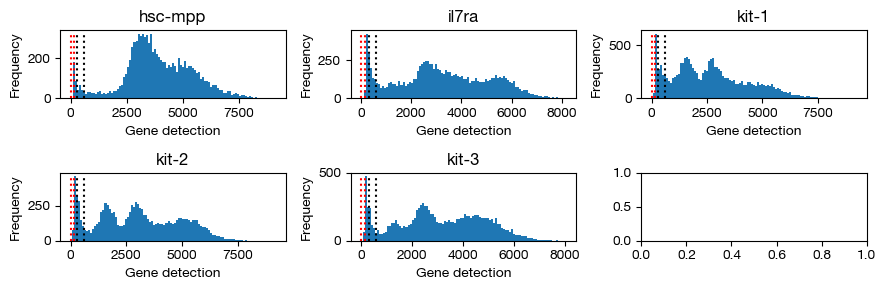

In [9]:
gene_counts = expm.plot_rna_qc_gene_counts(ncols = 3, figsize = (9, 3))

In [10]:
expm.run_rna_qc(
    run_on_samples = True,
    mt_seqid = 'chrM',
    mt_percent = 0.10,
    ribo_genes = None,
    ribo_percent = None,
    outlier_mode = 'mads',
    outlier_n = 5,
    doublet_method = 'scrublet',
    min_cells = 3,
    min_genes = 800
)

[i] found 13 mitochondrial genes (expected 13)
[i] found 115 ribosomal genes
quality controlling sample [hsc-mpp] ...
raw dataset contains 9868 cells, 18607 genes
[i] preprocessing observation count matrix ...
[i] simulating doublets ...
[i] embedding using pca ...
[i] calculating doublet scores ...
[i] detected doublet rate: 0.0 %
[i] estimated detectable doublet fraction: 0.5 %
[i] overall doublet rate: 2.2 %
filtered dataset contains 8770 cells, 16592 genes
[i] found 13 mitochondrial genes (expected 13)
[i] found 114 ribosomal genes
quality controlling sample [il7ra] ...
raw dataset contains 11277 cells, 18219 genes
[i] preprocessing observation count matrix ...
[i] simulating doublets ...
[i] embedding using pca ...
[i] calculating doublet scores ...
[i] detected doublet rate: 2.4 %
[i] estimated detectable doublet fraction: 55.9 %
[i] overall doublet rate: 4.4 %
filtered dataset contains 8458 cells, 16142 genes
[i] found 13 mitochondrial genes (expected 13)
[i] found 114 ribosomal

In [11]:
expm.save()

# filter rna modality, this will delete cells that do not pass qc criteria in the 'rna' modality data
# however, no changes will be applied to 'cite' modality
expm.run_rna_filter(run_on_samples = True)

# we need to dropped those cells in 'cite' manually
for sample in expm['rna'].keys():
    expm.modalities['cite'][sample] = expm.modalities['cite'][sample][
        expm['rna'][sample].obs_names, :
    ].copy()

[i] saving individual samples. (pass `save_samples = False` to skip)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━ modality [rna]           5 / 5     (00:02 < 00:00)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━ modality [cite]          5 / 5     (00:00 < 00:00)


In [12]:
expm.run_rna_log_normalize(
    run_on_samples = True,
    key_norm = 'norm',
    key_lognorm = 'lognorm'
)

expm.run_rna_select_hvg(
    run_on_samples = True,
    key_lognorm = 'lognorm',
    method = 'vst',
    dest = 'vst',
    n_top_genes = 1500
)

expm.merge(join = 'outer')

为了阅读的统一，我们对 CITE 模态进行重命名

In [13]:
expm['cite'].var_names = [
    'ag:CD62L', 'ag:CXCR3', 'ag:CD14', 'ag:SiglecF', 'ag:CX3CR1', 'ag:CD4',
    'ag:CD8a', 'ag:PD-1', 'ag:cKit', 'ag:Ly6C', 'ag:CD11b', 'ag:Ly6G',
    'ag:CD49f', 'ag:CD44', 'ag:CD54', 'ag:CD90.2', 'ag:CD73', 'ag:CD49d', 'ag:OX2',
    
    # isotype controls, mouse
    'iso:mIgG1', 'iso:mIgG2a', 'iso:mIgG2b', 
    
    'ag:CD19', 'iso:rIgG2b', 'ag:CD45', 'ag:CD25', 'ag:B220', 'ag:CD102', 'ag:CD11c',
    'ag:CR1/2', 'ag:CD23', 'ag:CD16/32', 'ag:CD43', 'ag:CD5', 'ag:AA4.1',
    'ag:F4/80', 'ag:I-A/I-E', 'ag:NK1.1', 'ag:SiglecH', 'ag:Ter-119',
    'ag:SCA-1', 'ag:CD45.2', 'ag:CD45.1', 'ag:CD3', 'ag:PD-L1', 'ag:CD27',
    'ag:CD20', 'ag:GITR', 'ag:CD69', 'ag:CD86', 'ag:CD150', 'ag:CD24', 'ag:Itg7', 'ag:CD106', 
    
    # isotype controls, rat
    'iso:rIgG1', 'iso:rIgG1.2', 'iso:rIgG2a', 'iso:rIgG2c', 
    
    # isotype controls, armenian hamster
    'iso:ahIgG',
    
    'ag:LAG-3', 'ag:CD300LG', 'ag:CD163', 'ag:CD49b', 'ag:CD172a', 'ag:CD48',
    'ag:EPCR', 'ag:Siglec1', 'ag:CD71', 'ag:CD41', 'ag:IgM', 'ag:CD36', 'ag:CD38',
    'ag:DAF', 'ag:CD63', 'ag:CD79b', 'ag:CD301b', 'ag:TIM-4', 'ag:CD29', 'ag:IgD',
    'ag:CD140a', 'ag:CD11a', 'ag:ESAM', 'ag:OX2R', 'ag:CCR3', 'ag:PDCA1', 'ag:CD105',
    'ag:CD9', 'ag:CLEC12a', 'ag:CD22', 'ag:ST2', 'ag:Ly49A', 'ag:CD49a', 'ag:Ly38',
    'ag:PIR-A/B', 'ag:DPP-4', 'ag:HVEM', 'ag:CD2', 'ag:CD40', 'ag:CD31', 'ag:CD107a',
    'ag:CXCR2', 'ag:CD61', 'ag:Fas', 'ag:NKG2AB6', 'ag:Ly108', 'ag:CD85k', 'ag:CD51',
    'ag:CD205', 'ag:PVR', 'ag:CD81', 'ag:FLK2', 'ag:IL7Ra',
]

expm['cite'].var['antigen'] = expm['cite'].var_names.tolist()
expm['cite'].var['is.isotype'] = expm['cite'].var_names.str.startswith('iso:')

expm['cite'].var['gene'] = [
    'Sell', 'Cxcr3', 'Cd14', 'Siglecf', 'Cx3cr1', 'Cd4',
    'Cd8a', 'Pdcd1', 'Kit', 'Ly6c1:Ly6c2', 'Itgam', 'Ly6g',
    'Itga6', 'Cd44', 'Icam1', 'Thy1', 'Nt5e', 'Itga4', 'Cd200',
    
    # isotype controls, mouse
    'iso:mIgG1', 'iso:mIgG2a', 'iso:mIgG2b', 
    
    'Cd19', 'iso:rIgG2b', 'Ptprc', 'Il2ra', 'Ptprc(R)', 'Icam2', 'Itgax',
    'Cr1l:Cr2', 'Fcer2a', 'Fcgr3:Fcgr2b', 'Spn', 'Cd5', 'Cd93',
    'Adgre1', 'H2-Aa', 'Klrb1c', 'Siglech', '?',
    'Ly6a:Ly6e', 'Ptprc^45.2', 'Ptprc^45.2', 'Cd3d:Cd3e:Cd3g', 'Cd274', 'Cd27',
    'Ms4a1', 'Tnfrsf18', 'Cd69', 'Cd86', 'Slamf1', 'Cd24a', 'Itga7', 'Vcam1', 
    
    # isotype controls, rat
    'iso:rIgG1', 'iso:rIgG1.2', 'iso:rIgG2a', 'iso:rIgG2c', 
    
    # isotype controls, armenian hamster
    'iso:ahIgG',
    
    'Lag3', 'Cd300lg', 'Cd163', 'Itga2', 'Sirpa', 'Cd48',
    'Procr', 'Siglec1', 'Tfrc', 'Itga2b', 'Ighm', 'Cd36', 'Cd38',
    'Cd55', 'Cd63', 'Cd79b', 'Mgl2', 'Timd4', 'Itgb1', 'Ighd',
    'Pdgfra', 'Itgal', 'Esam', 'Hcrtr2', 'Ccr3', 'Bst2', 'Eng',
    'Cd9', 'Clec12a', 'Cd22', 'Il1rl1', 'Klra1', 'Itga1', 'Cd1d',
    'Pirb:Pira*', 'Dpp4', 'Tnfrsf14', 'Cd2', 'Cd40', 'Pecam1', 'Lamp1',
    'Cxcr2', 'Itgb3', 'Fas', 'Klrc1', 'Slamf6', 'Lilrb4a', 'Itgav',
    'Ly75', 'Pvr', 'Cd81', 'Flt3', 'Il7r',
]

现在，我们已经同步和整合了 RNA 和 CITE 数据集

In [14]:
print(expm)

annotated data of size 45103 × 17925
annotated data of size 45103 × 112
integrated dataset of size 45103 × 18037
contains modalities: rna, cite

 modality [rna]
    obs : sample <cat> batch <cat> group <cat> modality <cat> taxa <cat> barcode <o> ubc <o>
          n.umi <f64> n.genes <i64> n.mito <f64> n.ribo <f64> pct.mito <f64> pct.ribo <f64>
          filter <bool> score.doublet <f64> score.doublet.se <f64> is.doublet <bool> qc <bool>
    var : chr <o> start <i64> end <i64> strand <o> id <o> subtype <o> gene <o> tlen <f64>
          cdslen <i64> assembly <o> uid <o>
 layers : counts <f32>

 modality [cite]
    obs : sample <cat> batch <cat> group <cat> modality <cat> taxa <cat> barcode <o> ubc <o>
    var : antigen <o> is.isotype <bool> gene <o>

[*] composed of samples:
  hsc-mpp   cite  mmu    batch b-1     of size 8770 × 112
  il7ra     cite  mmu    batch b-2     of size 8458 × 112
  kit-1     cite  mmu    batch b-3     of size 9869 × 112
  kit-2     cite  mmu    batch b-4     of 

In [15]:
expm.save(save_samples = False)

[i] main dataset write to cite/integrated.h5mu


### 基于 RNA 模态的可视化

我们先只基于 RNA 模态进行降维和可视化

In [16]:
expm.run_rna_select_hvg(
    key_lognorm = 'X',
    method = 'vst',
    dest = 'vst',
    batch_key = 'batch',
    n_top_genes = 3000
)

这里 cc-genes 是此前收集的小鼠细胞周期相关基因，我们排除掉这些基因，以细胞身份聚类

In [ ]:
import pickle
with open('cc-genes.pkl', 'rb') as f:
    cc_genes = pickle.load(f)
    
lateral_names = [
    'Atad2', 'Blm', 'Brip1', 'Casp8ap2', 'Ccne2', 'Cdc45', 'Cdc6', 'Cdca7', 'Chaf1b', 'Clspn', 
    'Dscc1', 'Dtl', 'E2f8', 'Exo1', 'Fen1', 'Gins2', 'Gmnn', 'Hells', 'Mcm2', 'Mcm4', 'Mcm5', 'Mcm6',
    'Msh2', 'Nasp', 'Pcna', 'Pola1', 'Pold3', 'Prim1', 'Rad51', 'Rad51ap1', 'Rfc2', 'Rpa2', 'Rrm1', 
    'Rrm2', 'Slbp', 'Tipin', 'Tyms', 'Ubr7', 'Uhrf1', 'Ung', 'Usp1', 'Wdr76', 'Anln', 'Anp32e', 'Aurka', 'Aurkb',
    'Birc5', 'Bub1', 'Cbx5', 'Ccnb2', 'Cdc20', 'Cdc25c', 'Cdca2', 'Cdca3', 'Cdca8', 'Cdk1', 'Cenpa', 
    'Cenpe', 'Cenpf', 'Ckap2', 'Ckap2l', 'Ckap5', 'Cks1b', 'Cks2', 'Ctcf', 'Dlgap5', 'Ect2',
    'G2e3', 'Gas2l3', 'Gtse1', 'Hjurp', 'Hmgb2', 'Hmmr', 'Kif11', 'Kif20b', 'Kif23', 'Kif2c', 'Lbr', 
    'Mki67', 'Ncapd2', 'Ndc80', 'Nek2', 'Nuf2', 'Nusap1', 'Psrc1', 'Rangap1', 'Smc4', 'Tacc3',
    'Tmpo', 'Top2a', 'Tpx2', 'Ttk', 'Tubb4b', 'Ube2c', # cell cycle genes
    'Arhgap36', 'Rbm3', 'Sytl4', 'Malat1' # sex related genes
]

expm['rna'].var['vst.hvg'] = [
    x if gname not in lateral_names else False for x, gname in zip(
    expm['rna'].var['vst.hvg'], expm['rna'].var['gene']
)]

expm['rna'].var['vst.hvg'] = [
    x if gname not in cc_genes.tolist() else False for x, gname in zip(
    expm['rna'].var['vst.hvg'], expm['rna'].var.index
)]

expm['rna'].var['vst.hvg'].value_counts()

In [ ]:
expm.run_rna_scvi(
    batch = 'batch', n_comps = 30, 
    hvg = 'vst.hvg', key_counts = 'counts',
)

In [20]:
expm.run_rna_knn(
    use_rep = 'scvi',
    n_comps = None,
    n_neighbors = 30,
    knn = True,
    method = "umap",
    transformer = None,
    metric = "cosine",
    metric_kwds = {},
    random_state = 42,
    key_added = 'nn',
    use_gpu = True
)

expm.run_rna_umap(
    min_dist = 0.3,
    spread = 1.5,
    n_components = 2,
    maxiter = None,
    alpha = 1,
    gamma = 1,
    negative_sample_rate = 5,
    init_pos = "spectral",
    random_state = 42,
    a = None, b = None,
    key_added = 'umap',
    neighbors_key = "nn"
)

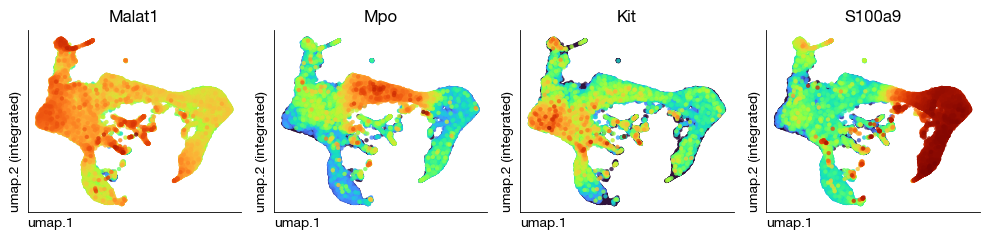

In [21]:
fig = expm.plot_rna_embedding_multiple(
    basis = 'umap', features = ['Malat1', 'Mpo', 'Kit', 'S100a9'], ncols = 4,
    sort = True, figsize = (10, 2.5), dpi = 100, legend_col = 2
)

### CITE 模态标准化

CITE 模态一般使用中心对数比进行标准化，而不是普通的对数标准化

In [22]:
expm.run_cite_clr_normalize(
    key_source = 'X', 
    key_added = 'clr'
)

我们将 RNA 的 UMAP 复制到 CITE 模块中

In [23]:
expm['cite'].obsm['umap'] = expm['rna'].obsm['umap']

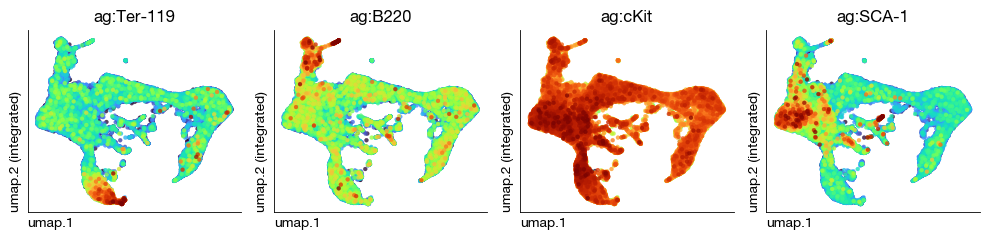

In [24]:
fig = expm.plot_cite_embedding_multiple(
    basis = 'umap', features = ['ag:Ter-119', 'ag:B220', 'ag:cKit', 'ag:SCA-1'], ncols = 4,
    sort = True, figsize = (10, 2.5), dpi = 100, legend_col = 2, cmap = 'turbo', remove_top = 50
)

### 门控策略

人们往往希望表面蛋白展示出如经典蛋白组所示的门控策略，尽管这期间并不等同. 这个操作最常用于表面
蛋白的谱系追踪或样本标记，因为这时蛋白的标记差异是非常显著的（例如 Sample HashTag 或 CD45.1/2）

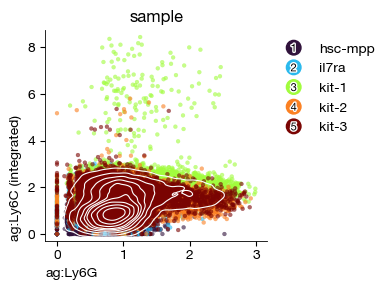

In [26]:
fig = expm.plot_cite_gene_gene(
    gene_x = 'ag:Ly6G', gene_y = 'ag:Ly6C',
    color = 'sample', alpha = 0.6, annotate = False,
    legend = True, legend_col = 1, annotate_style = 'text',
    contour_plot = True, contour_bw = 0.8, contour_default_color = 'white',
    figsize = (4, 3), dpi = 100,
    cmap = 'turbo',

    remove_zero_expression = False,
    scale = 'linear', arcsinh_divider = None
)

In [34]:
expm.run_cite_gate_polygon(
    gene_x = 'ag:Ly6G',
    gene_y = 'ag:Ly6C',
    layer = 'X',
    remove_zero_expression = False,
    scale = 'asis',
    arcsinh_divider = None,
    polygon = [(1.6, 0.5), (3.2, 0.5), (3.2, 3.5), (1.6, 3.5)],
    key_added = 'gate'
)

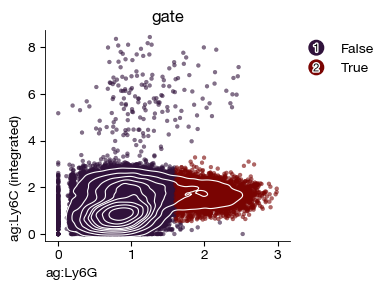

In [35]:
fig = expm.plot_cite_gene_gene(
    gene_x = 'ag:Ly6G', gene_y = 'ag:Ly6C',
    color = 'gate', alpha = 0.6, annotate = False,
    legend = True, legend_col = 1, annotate_style = 'text',
    contour_plot = True, contour_bw = 0.8, contour_default_color = 'white',
    figsize = (4, 3), dpi = 100,
    cmap = 'turbo',

    remove_zero_expression = False,
    scale = 'linear', arcsinh_divider = None
)

你可以进一步在原有的 UMAP 图形上显示这一子集

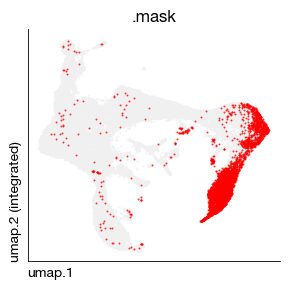

In [37]:
expm['rna'].obs['ly6g-hi'] = expm['cite'].obs['gate']
fig = expm.plot_rna_embedding_mask(
    basis = 'umap', color = 'ly6g-hi', values = ['True'],
    figsize = (3, 3), ptsize = 1.5
)

### 保存数据集

保存整合的数据集

In [ ]:
expm.save(save_samples = False)

[i] main dataset write to cite/integrated.h5mu
